In [99]:
import numpy as np
import tensorflow_probability as tfp
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

In [100]:
class Gaussian:

    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma
        self.distr = tfp.distributions.Normal(self.mu, self.sigma)

    def pdf(self, x):
        return self.distr.prob(x)

    def sample(self, n):
        return self.distr.sample(n)



In [101]:
np.random.seed(2)

f_1 = Gaussian(np.random.uniform(-10, 10),  np.random.uniform(1, 5))
n1 = np.random.randint(100, 200)
cluster_1 = f_1.sample(n1)

f_2 = Gaussian(np.random.uniform(-10, 10),  np.random.uniform(1, 5))
n2 = np.random.randint(100, 200)
cluster_2 = f_2.sample(n2)

print(f_1.mu, f_1.sigma)
print(f_2.mu, f_2.sigma)

-1.2801019571599248 1.1037049273115653
8.954612230557558 2.9389963871350226


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


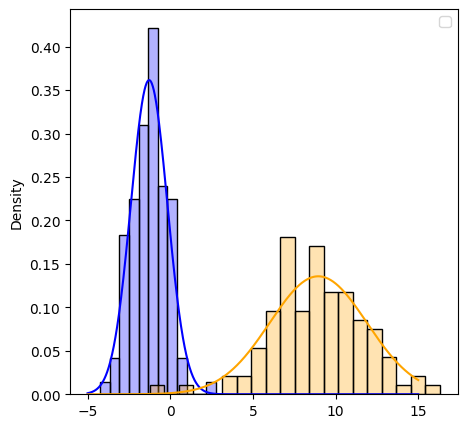

In [102]:
x = np.linspace(-5, 15, 1000)
fig = plt.figure(figsize=(5,5))


sns.histplot(cluster_1, stat='density', alpha=0.3, color='blue')
plt.plot(x, f_1.pdf(x), color='blue')
#plt.scatter(cluster_1, np.zeros(len(cluster_1)), color='red', marker='o')

sns.histplot(cluster_2, stat='density', bins=20,alpha=0.3, color='orange',)
plt.plot(x, f_2.pdf(x), color='orange')

plt.legend()

plt.show()


In [103]:
data = np.concatenate((cluster_1.numpy(), cluster_2.numpy()))
# data

array([-1.08088326e+00, -2.47767687e+00, -7.45543957e-01, -5.59880912e-01,
       -1.01132917e+00, -2.80578518e+00, -2.56661296e+00, -9.23584700e-01,
       -3.58921289e-01, -1.24049783e+00, -2.85234165e+00, -1.05605149e+00,
       -2.40384197e+00, -1.38905919e+00, -7.14774549e-01,  2.74095893e+00,
       -2.36252546e+00, -2.21095514e+00, -2.55094481e+00,  8.50167990e-01,
        2.49831080e-01, -1.58002377e-01, -1.09820664e+00, -2.21415758e-02,
       -2.19898081e+00,  2.93645740e-01, -7.11827278e-02, -4.25429630e+00,
       -3.08961129e+00, -6.81286275e-01, -2.07452393e+00,  8.43247175e-02,
       -8.49986792e-01, -1.21126795e+00, -9.45325017e-01, -1.44168973e+00,
       -4.23686683e-01, -1.85510397e+00, -1.44774222e+00, -2.15278769e+00,
       -1.63018131e+00, -1.01868773e+00, -3.19374847e+00, -9.88796115e-01,
       -2.39337492e+00, -1.98879242e-01,  1.68802023e-01, -1.73961782e+00,
       -1.28573024e+00, -2.70946789e+00, -1.27986312e-01, -9.37448502e-01,
       -3.15054953e-01,  

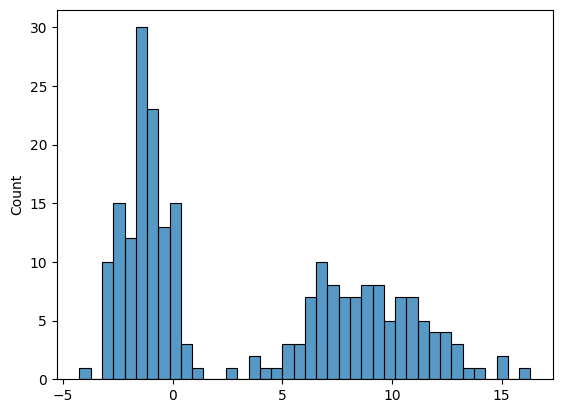

In [104]:
fig = plt.figure()

sns.histplot(data, bins=40)
plt.show()

In [113]:
def Gibbs_Sampler(data, n_clus, niter, burnin):
    weights = np.ones(n_clus) / n_clus
    alpha = np.ones(n_clus)
    cluster_allocs = tfp.distributions.Categorical(weights).sample(len(data)).numpy()
    
    a0 = 1
    b0 = 1

    mu0 = tfp.distributions.Normal(np.mean(data), np.float32(1/np.var(data))).sample().numpy()
    tau0 = tfp.distributions.Gamma(a0, b0).sample().numpy()
    
    cluster_allocs_out = []
    mu_out = []
    tau_out = []
    weights_out = []

    for i in range(niter):
        mu_iter = []
        tau_iter = []

        n_of_clus = np.array([np.sum(cluster_allocs == j) for j in range(n_clus)]) 
        weights = tfp.distributions.Dirichlet(alpha+n_of_clus).sample().numpy()

        # one step Gibbs
        for j in range(n_clus):
            clusdata = data[cluster_allocs == j]
            clusmean = np.mean(clusdata)

            tau_clus = tfp.distributions.Gamma(a0+len(clusdata)/2, b0+(np.sum((clusdata-clusmean)**2))/2).sample().numpy()
           
            delta = (len(clusdata)*tau_clus) / (tau0 + len(clusdata)*tau_clus)
            mu_clus = tfp.distributions.Normal(delta*clusmean+(1-delta)*mu0, tau0+len(clusdata)*tau_clus).sample().numpy()
            
            tau_iter.append(tau_clus)
            mu_iter.append(mu_clus)

        
        cluster_allocs_iter = tfp.distributions.Categorical(weights).sample(len(data)).numpy()
        
        weights_out.append(weights)
        tau_iter.append(tau_iter)
        mu_out.append(mu_iter)
        cluster_allocs_out.append(cluster_allocs_iter)

    return cluster_allocs_out, mu_out, tau_out, weights_out
        
        

z, mu, tau, w = Gibbs_Sampler(data, 2, 100, 1)





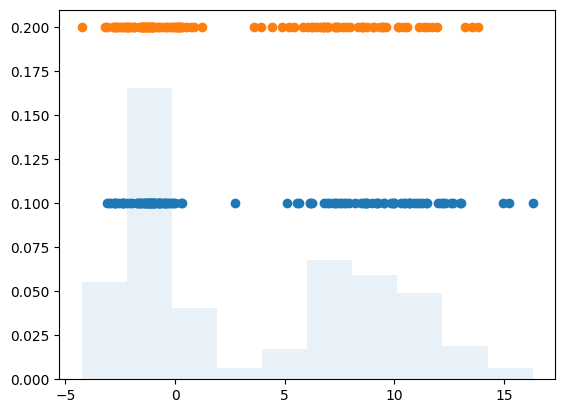

In [107]:
plt.hist(data, density=True, alpha=0.1)
for h in range(2):
    currd = data[z[-1] == h]
    plt.scatter(currd, np.zeros_like(currd) + 0.1 * (h+1))